Unfortunately, Neural Networks don’t understand text data. To deal with the issue, you must figure out a way to convert text into numbers. There are a variety of ways to solve the problem, but most well-performing models use Embeddings. <br>
source: https://curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/

### Hotel Reviews dataset
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

In [ ]:
# Download the dataset directly from google drive
!gdown --id 1tePKK3szVUuzewJNwLRbwDgJjkEnZWNf

Downloading...
From: https://drive.google.com/uc?id=1tePKK3szVUuzewJNwLRbwDgJjkEnZWNf
To: /content/Hotel_Reviews.csv
238MB [00:01, 201MB/s]


In [ ]:
import pandas as pd

df = pd.read_csv("Hotel_Reviews.csv", parse_dates=['Review_Date'])

In [ ]:
df.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Hotel_Address                               515738 non-null  object        
 1   Additional_Number_of_Scoring                515738 non-null  int64         
 2   Review_Date                                 515738 non-null  datetime64[ns]
 3   Average_Score                               515738 non-null  float64       
 4   Hotel_Name                                  515738 non-null  object        
 5   Reviewer_Nationality                        515738 non-null  object        
 6   Negative_Review                             515738 non-null  object        
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64         
 8   Total_Number_of_Reviews                     515738 non-null  int64        

There are a lot of information to be consider but this work we are considering only review text and review score.

In [ ]:
df["review"] = df["Negative_Review"] + df["Positive_Review"]
df["review_type"] = df["Reviewer_Score"].apply(
    lambda x: "bad" if x < 7 else "good"
)

df = df[["review", "review_type"]]

#### Exploring the dataset

In [ ]:
df.review_type.value_counts()

good    428887
bad      86851
Name: review_type, dtype: int64

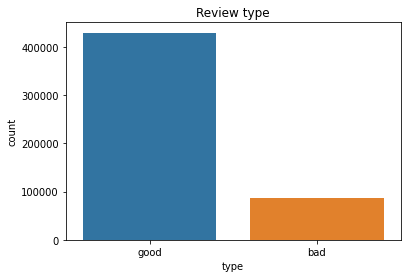

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

In [ ]:
good_reviews = df[df.review_type == "good"]
bad_reviews = df[df.review_type == "bad"]

print(good_reviews.shape, bad_reviews.shape)

(428887, 2) (86851, 2)


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show()

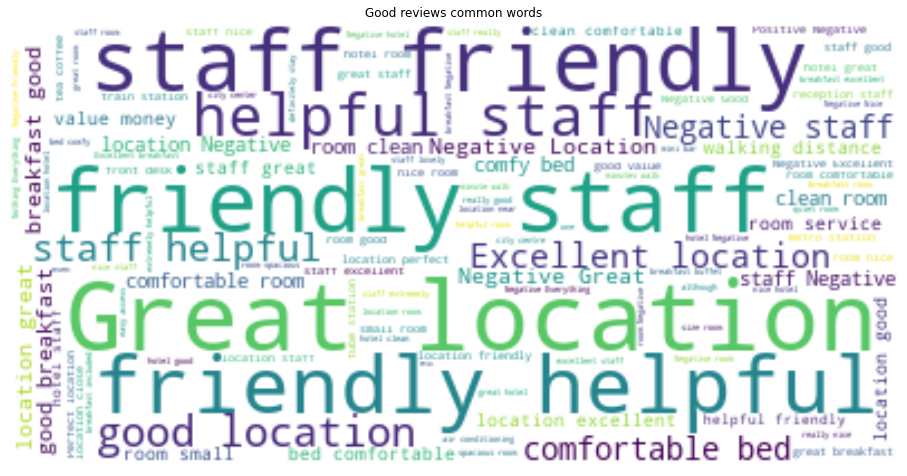

In [ ]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")

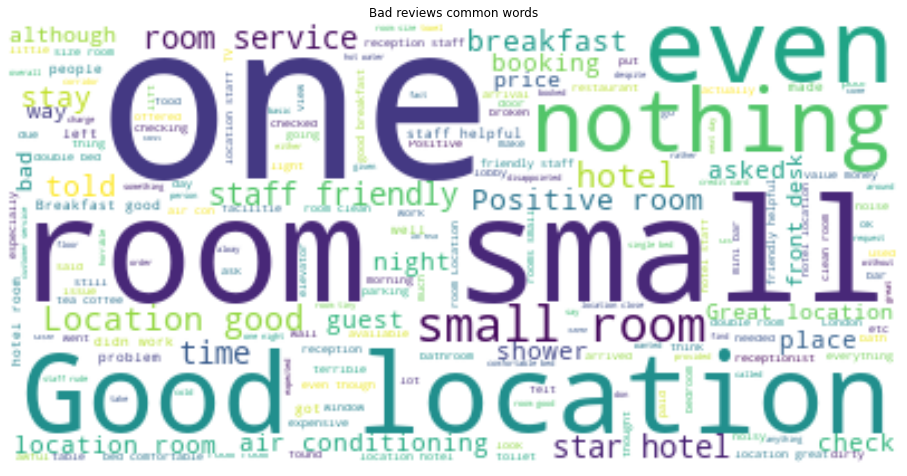

In [ ]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

### Data Wrangling/Data Cleansing
Reduce the size of good reviews equal to bad reviews

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews))
bad_df = bad_reviews

In [ ]:
print(good_df.shape, bad_df.shape)

(86851, 2) (86851, 2)


In [ ]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

(173702, 2)

In [ ]:
review_df.head()

,review,review_type
0,Pricy and rooms are too small Location is ver...,good
1,Administration charged prior to arrival and w...,good
2,Furniture in room sort of just plunked in Did...,good
3,No Negative Nice room very quite air condition...,good
4,location is near the rai convention center bu...,good


Text(0.5, 1.0, 'Review type (resampled)')

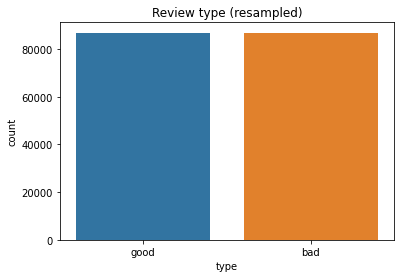

In [ ]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)")

### Data Preprocessing

In [ ]:
# One Hot encoding
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [ ]:
from sklearn.model_selection import train_test_split

# Train and Test split data
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1,
  )

### Universal Sentence Encoder
[Paper about Universal Sentence Encoder](https://arxiv.org/abs/1803.11175)
Instead of we use manual embedding, why not we use the [existing one](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3) from tensorflow. <br>
![](https://www.gstatic.com/aihub/tfhub/universal-sentence-encoder/example-classification.png)
The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

In [ ]:
!pip install tensorflow_text>=2.0.0rc0

In [ ]:
import tensorflow_hub as hub
import tensorflow_text

# source: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
# source: https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [ ]:
# Example
sent_1 = ["the location is great"]
emb_1 = use(sent_1)
emb_1.shape

TensorShape([1, 512])

In [ ]:
# Encoding
from tqdm import tqdm
import numpy as np
import tensorflow as tf

X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 156331/156331 [17:52<00:00, 145.71it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 17371/17371 [02:00<00:00, 144.50it/s]


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(156331, 512) (156331, 2) (17371, 512) (17371, 2)


### Sentiment Analysis

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout

# Define the neural network
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(2, activation='softmax')
])

In [ ]:
from tensorflow import keras

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.4377 - accuracy: 0.7937 - val_loss: 0.4325 - val_accuracy: 0.7960
Epoch 2/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.4117 - accuracy: 0.8086 - val_loss: 0.4190 - val_accuracy: 0.8022
Epoch 3/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.3977 - accuracy: 0.8175 - val_loss: 0.4293 - val_accuracy: 0.8009
Epoch 4/10
8794/8794 [==============================] - 22s 3ms/step - loss: 0.3844 - accuracy: 0.8243 - val_loss: 0.4199 - val_accuracy: 0.8043
Epoch 5/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.3702 - accuracy: 0.8322 - val_loss: 0.4247 - val_accuracy: 0.8014
Epoch 6/10
8794/8794 [==============================] - 22s 3ms/step - loss: 0.3550 - accuracy: 0.8394 - val_loss: 0.4342 - val_accuracy: 0.8029
Epoch 7/10
8794/8794 [==============================] - 22s 3ms/step - loss: 0.3406 - accuracy: 0.8477 - val_loss: 0.4402 - val_ac

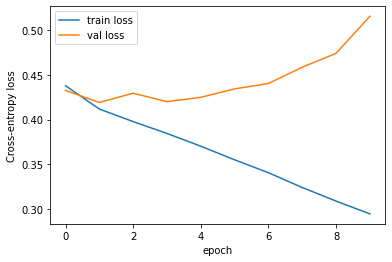

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()

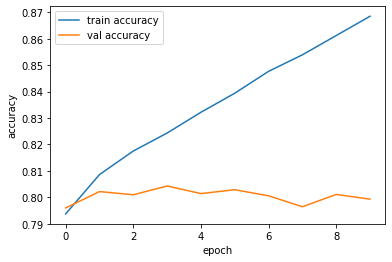

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
# Define the new neural network with reducing the overfitting
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(rate=0.5),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(2, activation='softmax')
])

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

RuntimeError: ignored

In [ ]:
print(model.metrics_names)
model.evaluate(X_test, y_test)

### Make prediction

In [ ]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

In [ ]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

In [ ]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")

In [ ]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
print("Bad" if np.argmax(y_pred) == 0 else "Good")

In [ ]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

In [ ]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
print("Bad" if np.argmax(y_pred) == 0 else "Good")